<a href="https://colab.research.google.com/github/lakatosgabor/nav_uzemanyag_havi_info/blob/main/nav_uzemanyag_havi_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime

'''
DATAFRAME ADATSTRUKTÚRA
       2023.év Ólmozatlan motorbenzin ESZ-95  (Ft/l) Gázolaj (Ft/l)  Keverék (Ft/l) LPG autógáz (Ft/l) CNGautógáz(Ft/kg)
0       január                                   655            713   530                407              1991

AZ OSZLOP INDEXEK HIVATKOZÁSHOZ
['2023.év', 'Ólmozatlan motorbenzin ESZ-95\xa0 (Ft/l)', 'Gázolaj (Ft/l)', 'Keverék (Ft/l)', 'LPG autógáz (Ft/l)', 'CNGautógáz(Ft/kg)']
'''

url = "https://nav.gov.hu/print/ugyfeliranytu/uzemanyag/" + str(datetime.datetime.now().year) + "-ban-alkalmazhato-uzemanyagarak"

#number_of_month = 10 # 1: január, 2: február, 3: március ... min 1, max 12

number_of_month = datetime.datetime.now().month #aktuális hónap sorszáma az aktuális hónap adatainak lekérdezéséhez

def get_data(url, number_of_month):
    try:
        if type(number_of_month) != int:
            raise ValueError("Hibás hónap formátum. 1 és 12 közötti hónap számot adhat meg!")
            return 0

        if (number_of_month > 12 or number_of_month < 1):
            raise ValueError("A megadott hónap sorszám nem létezik. Adjon meg 1 és 12 közötti sorszámot!")
            return 0

        month_index = number_of_month - 1
        response = requests.get(url)
        response.raise_for_status()  # Dobjon kivételt, ha hiba történt a lekérdezésnél
        soup = BeautifulSoup(response.content, "html.parser")
        table = soup.find("table")

        if table is None:
            raise ValueError("Nem található táblázat az oldalon.")
            return 0

        table_rows = table.find_all("tr")
        data = []
        for row in table_rows:
            cols = row.find_all(["th", "td"])
            cols = [col.text.strip() for col in cols]
            data.append(cols)

        if len(data) < 2:
            raise ValueError("A táblázatban nincsenek adatok.")
            return 0

        df = pd.DataFrame(data[1:], columns=data[0])[::-1].reset_index(drop=True)

        if str(datetime.datetime.now().year) + '.év' not in df.columns or 'Gázolaj (Ft/l)' not in df.columns or 'LPG autógáz (Ft/l)' not in df.columns or 'Ólmozatlan motorbenzin ESZ-95\xa0 (Ft/l)' not in df.columns:
            raise ValueError("Hiányzó oszlopok a táblázatban.")
            return 0

        if len(df[data[0][0]]) < number_of_month:
            raise ValueError("A " + str(number_of_month) + ". hónap üzemanyag árai még nem elérhetőek. Jelenleg " + str(len(df[data[0][0]])) + ". hónapig állnak rendelkezésre adatok.")
            return 0

        selected_month = df[data[0][0]][month_index]
        disel = df[data[0][2]][month_index]
        lpg_gas = df[data[0][4]][month_index]
        petrol = df[data[0][1]][month_index]

        return selected_month, disel, lpg_gas, petrol

    except requests.exceptions.HTTPError as errh:
        print("HTTP hiba történt:", errh)
        return 0
    except requests.exceptions.ConnectionError as errc:
        print("Kapcsolódási hiba történt:", errc)
        return 0
    except requests.exceptions.Timeout as errt:
        print("Időtúllépés történt:", errt)
        return 0
    except requests.exceptions.RequestException as err:
        print("Kérési hiba történt:", err)
        return 0
    except ValueError as ve:
        print(ve)
        return 0


def main():
  if (get_data(url, number_of_month) == 0):
    return

  selected_month, disel, lpg_gas, petrol = get_data(url, number_of_month)

  if selected_month is not None:
      query_time = datetime.datetime.now()
      print("Hónap: ", selected_month)
      print("Gázolaj: ", disel)
      print("LPG gáz: ", lpg_gas)
      print("Petrol: ", petrol)
      print("Lekérdezés ideje: ", query_time)
  else:
      print("Nem sikerült lekérdezni az adatokat.")


main()


Hónap:  október
Gázolaj:  661
LPG gáz:  318
Petrol:  647
Lekérdezés ideje:  2023-10-30 08:54:05.464900


Ólmozatlan motorbenzin ESZ-95  (Ft/l) - Aktuális havi érték: 645 Ft/l, Következő havi lehetséges érték: 610.33 Ft/l
Gázolaj (Ft/l) - Aktuális havi érték: 721 Ft/l, Következő havi lehetséges érték: 592.62 Ft/l
Keverék (Ft/l) - Aktuális havi érték: 695 Ft/l, Következő havi lehetséges érték: 691.31 Ft/l
LPG autógáz (Ft/l) - Aktuális havi érték: 399 Ft/l, Következő havi lehetséges érték: 287.93 Ft/l
CNGautógáz(Ft/kg) - Aktuális havi érték: 1481 Ft/l, Következő havi lehetséges érték: 527.69 Ft/l


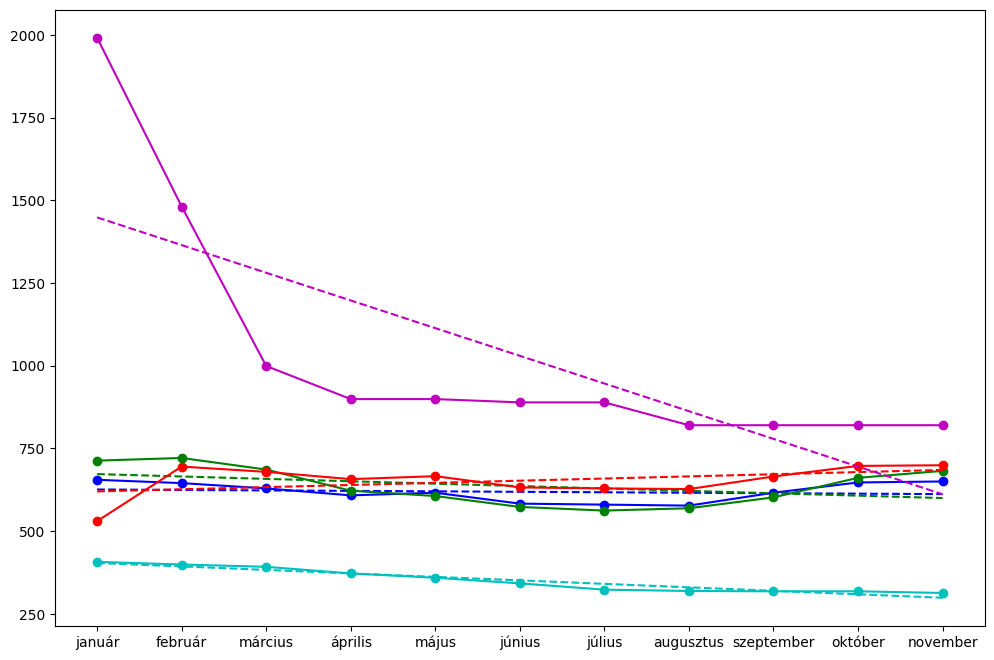

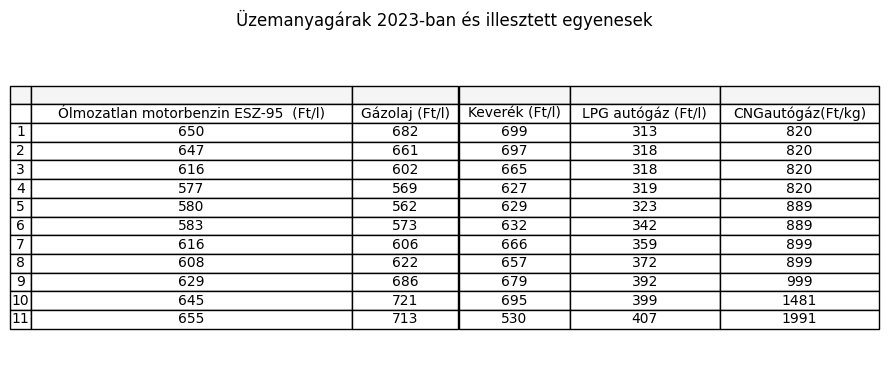

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

response = requests.get(url)
response.raise_for_status()  # Dobjon kivételt, ha hiba történt a lekérdezésnél
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("table")

table_rows = table.find_all("tr")
data = []
for row in table_rows:
    cols = row.find_all(["th", "td"])
    cols = [col.text.strip() for col in cols]
    data.append(cols)

df = pd.DataFrame(data[1:], columns=data[0])[::-1].reset_index(drop=True)

# Diagram készítése
plt.figure(figsize=(12, 8))

# Adatsorok elnevezése és színek kiválasztása
adatsorok = data[0][1:]
szinek = ['b', 'g', 'r', 'c', 'm']

# Egyenes illesztése és következő havi érték meghatározása minden adatsorhoz
for i in range(len(adatsorok)):
    x = np.arange(len(df['2023.év']))
    y = df[adatsorok[i]].astype(int).values

    # Lineáris regresszió illesztése az adott adatsorra
    coeffs = np.polyfit(x, y, 1)
    fitted_line = np.polyval(coeffs, x)

    # Diagramra rajzolás
    plt.plot(df['2023.év'], fitted_line, color=szinek[i], linestyle='--', label=f'Illesztett - {adatsorok[i]}')
    plt.plot(df['2023.év'], y, marker='o', color=szinek[i], label=adatsorok[i])

    # Következő havi lehetséges érték meghatározása
    next_month_index = len(df['2023.év'])
    next_month_value = np.polyval(coeffs, next_month_index)

    # Aktuális havi érték
    current_month_value = df[adatsorok[i]].iloc[1]

    print(f'{adatsorok[i]} - Aktuális havi érték: {current_month_value} Ft/l, Következő havi lehetséges érték: {next_month_value:.2f} Ft/l')


# Az előző kód része, a weboldalról származó adatok beolvasása és DataFrame létrehozása

# Táblázat készítése az adatokkal
plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.axis('off')  # A táblázat kirajzolása előtt kikapcsoljuk az axis-t

# A table_data listában minden sorban ugyanannyi oszlop legyen
max_columns = max(len(row) for row in data)
table_data = []

for i, row in enumerate(data):
    # Hiányzó értékeket (ha vannak) 0-ra állítjuk
    if i == 0:
        table_data.append([''] + row[1:])  # Az első oszlopban az első sor üres lesz
    else:
        table_data.append([f'{i}'] + row[1:])
    row += ['0'] * (max_columns - len(row))


table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=None, colColours=['#f5f5f5'] * len(data[0]))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data[0]))))  # Megfelelő oszlopok szélességének beállítása


plt.xlabel('Hónap')
plt.ylabel('Ár (Ft)')
plt.title('Üzemanyagárak 2023-ban és illesztett egyenesek')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()